In [28]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

dict_keys(['__header__', '__version__', '__globals__', 'data_train'])
(301, 33)
0
Outlier percentage: 49.83%


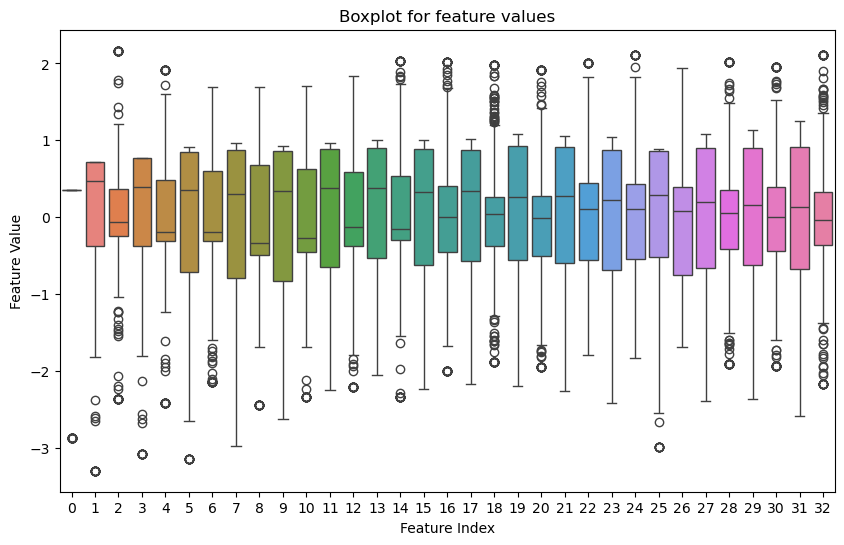

dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
(301, 1)
(50, 33)
Outlier percentage: 54.00%


(array([-1,  1], dtype=int16), array([106, 195]))

In [29]:
data_tr=scipy.io.loadmat('data_train.mat')
data_te=scipy.io.loadmat('data_test.mat')
label_tr=scipy.io.loadmat('label_train.mat')
scaler=StandardScaler()

print(data_tr.keys())
X=data_tr['data_train']
print(X.shape)
print(np.isnan(X).sum())
def IQR(X):
    Q1=np.percentile(X,25,axis=0)
    Q3=np.percentile(X,75,axis=0)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers=((X<lower_bound)|(X>upper_bound)).sum()
    #outlier percentage
    row_has_outlier = ((X < lower_bound) | (X > upper_bound)).any(axis=1)
    return row_has_outlier.sum() / X.shape[0] * 100
print(f'Outlier percentage: {IQR(X):.2f}%')
# X=scaler.fit_transform(X)

#outlier check
plt.figure(figsize=(10,6))
sns.boxplot(data=X)
plt.title('Boxplot for feature values')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.savefig('fig/boxplot_features.png')
plt.show()

print(label_tr.keys())
y=label_tr['label_train']
print(y.shape)

X_test=data_te['data_test']
# X_test=scaler.transform(X_test)
print(X_test.shape)
print(f'Outlier percentage: {IQR(X_test):.2f}%')
##judge the distribution of labels
np.unique(y,return_counts=True)

 

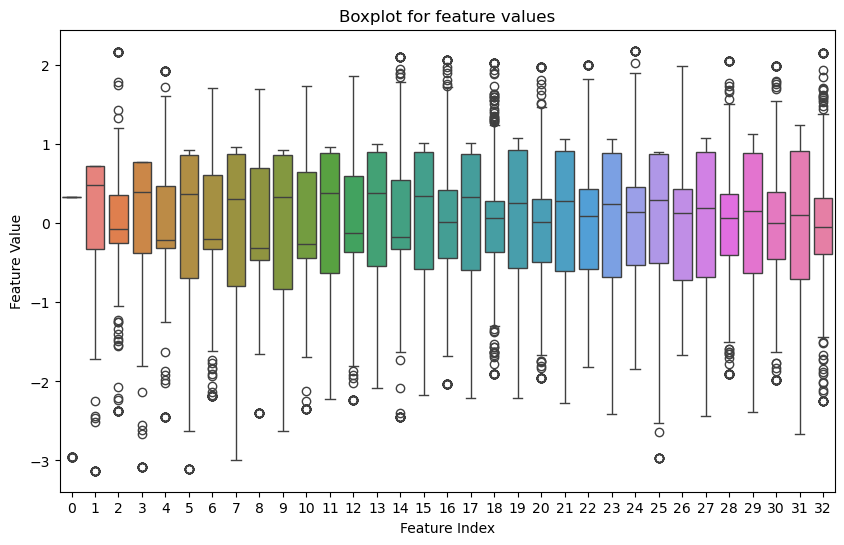

array([ 1.47537943e-17,  5.60644185e-17,  2.95075887e-18, -7.37689717e-18,
       -2.36060710e-17,  5.31136596e-17, -1.77045532e-17, -2.80322093e-17,
        2.06553121e-17, -4.13106242e-17, -1.47537943e-18, -3.09829681e-17,
       -4.13106242e-17, -2.06553121e-17,  1.18030355e-17, -5.90151774e-18,
        1.77045532e-17, -5.90151774e-18, -2.21306915e-17,  7.37689717e-18,
        0.00000000e+00, -5.90151774e-18, -2.36060710e-17,  6.49166951e-17,
       -7.37689717e-19, -2.36060710e-17, -1.18030355e-17, -5.90151774e-18,
        1.47537943e-17, -5.01629008e-17, -2.50814504e-17,  1.18030355e-17,
       -3.54091064e-17])

In [30]:
X=scaler.fit_transform(X)
plt.figure(figsize=(10,6))
sns.boxplot(data=X)
plt.title('Boxplot for feature values')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.savefig('fig/boxplot_features.png')
plt.show()

X.mean(axis=0)

## Input Layer
Since the train data have 33 features, the input layer should have 33 neurons.

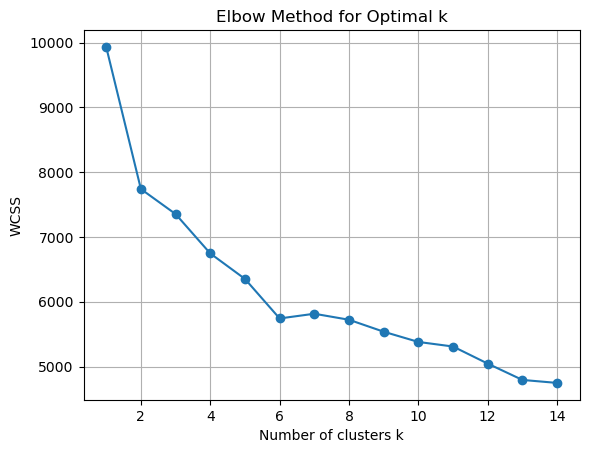

In [31]:
## Neuron centres selection
## Kmeans method
import numpy as np

class ncs_Kmeans:
    def __init__(self, X, n_clusters, max_iters=300, tol=1e-4):
        self.X = X
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.n_samples, self.n_features = X.shape

    def fit(self):
        np.random.seed(42)
        indices = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centres = self.X[indices].copy()

        for _ in range(self.max_iters):
            distances = np.linalg.norm(self.X[:, np.newaxis] - self.centres, axis=2)
            clusters = np.argmin(distances, axis=1)

            new_centres = np.zeros_like(self.centres)
            for i in range(self.n_clusters):
                points = self.X[clusters == i]
                if len(points) > 0:
                    new_centres[i] = points.mean(axis=0)
                else:
                    new_centres[i] = self.X[np.random.choice(self.n_samples)]

            center_shift = np.linalg.norm(self.centres - new_centres)
            if center_shift < self.tol:
                break
            
            self.centres = new_centres

        self.clusters = clusters
        return self.centres, self.clusters
## elbow method with WCSS to select number of clusters  
wcss=[]
for k in range(1,15):
    kmeans=ncs_Kmeans(X, n_clusters=k)
    centres, clusters=kmeans.fit()
    wcss_k=0
    for i in range(k):
        points=X[clusters==i]
        wcss_k+=np.sum((points - centres[i])**2)
    wcss.append(wcss_k)
plt.plot(range(1,15), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS')
plt.grid()
plt.savefig('fig/elbow_k_select.png')
plt.show()


In [42]:
##select k=6
from sklearn.cluster import KMeans
kmeans_sk= KMeans(n_clusters=6, random_state=0).fit(X)
centres_sk=kmeans_sk.cluster_centers_

kmeans=ncs_Kmeans(X, n_clusters=6)
centres, clusters=kmeans.fit()
print("Centres shape:", centres.shape)

def distance(a,b):
    return np.linalg.norm(a-b)

class RBFNN:
    def __init__(self, X, centres, sigma):
        self.X=X
        self.centres=centres
        self.sigma=sigma
        self.n_centres=centres.shape[0]
    
    def gaussian_rbf(self,x,centre):
        return np.exp(-np.linalg.norm(x-centre)**2/(2*self.sigma**2))
    
    def hidden_layer_activation(self):
        n_samples=self.X.shape[0]
        H=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H[i,j]=self.gaussian_rbf(self.X[i], self.centres[j])
        return H
    
    def train(self,y):
        H=self.hidden_layer_activation()
        H_bias=np.hstack((np.ones((H.shape[0],1)), H))
        self.weights=np.linalg.pinv(H_bias).dot(y)
        self.W=self.weights

    def predict(self, X_test):
        n_samples=X_test.shape[0]
        H_test=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H_test[i,j]=self.gaussian_rbf(X_test[i], self.centres[j])
        H_test_bias=np.hstack((np.ones((H_test.shape[0],1)), H_test))
        y_temp=H_test_bias.dot(self.weights)
        y_pred=np.where(y_temp>=0,1,-1)
        self.H=H_test_bias
        return y_pred
    
    ##check coverage and sigma
    def check(self):
        return self.W, self.H
        

##compute sigma with d_{max}/sqrt(2*n_centres)
# d_max=0
# for i in range(centres.shape[0]):
#     for j in range(i+1, centres.shape[0]):
#         d=distance(centres[i], centres[j])
#         if d>d_max:
#             d_max=d
# sigma=d_max/np.sqrt(2*centres.shape[0])
# print("Sigma:", sigma)
# rbfnn=RBFNN(X, centres, sigma)

d_max=0
for i in range(centres_sk.shape[0]):
    for j in range(i+1, centres_sk.shape[0]):
        d=distance(centres_sk[i], centres_sk[j])
        if d>d_max:
            d_max=d
sigma=d_max/np.sqrt(2*centres_sk.shape[0])
print("Sigma:", sigma)
rbfnn=RBFNN(X, centres_sk, sigma)


rbfnn.train(y)
y_pred=rbfnn.predict(X_test)

np.unique(y_pred, return_counts=True)

W,H=rbfnn.check()

print("Weights:", W.flatten())

print(f"Prediction:{y_pred.flatten()}")

Centres shape: (6, 33)
Sigma: 2.4604330308247047
Weights: [-0.71210723  1.44917781  2.56941916  2.50498441  1.85853228 -0.60277392
  1.59689277]
Prediction:[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1
 -1  1 -1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1
  1  1]


Confusion Matrix:
[[101   5]
 [ 19 176]]
Accuracy: 0.920265780730897
Precision: 0.9070211786372007
Recall: 0.9276971456216739
F1 Score: 0.9149877612502353
Sigma: 2.4604
Poor coverage number: 36 / 301
Blind spots: 0


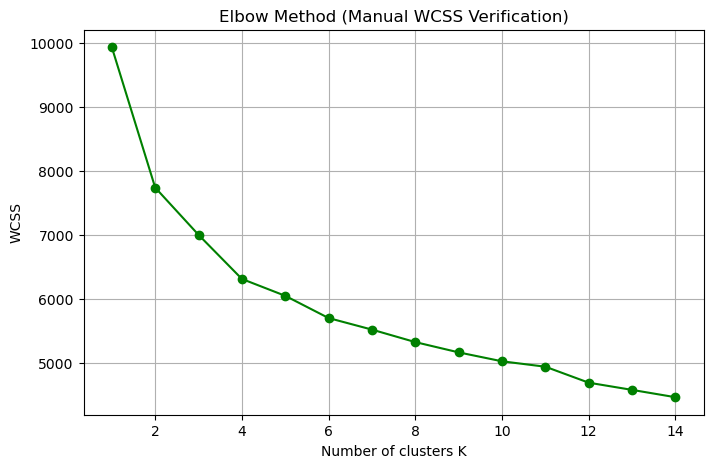

Centres from custom KMeans vs sklearn KMeans:
Custom centre 0 is closest to sklearn centre 0 with distance 0.2143
Custom centre 1 is closest to sklearn centre 5 with distance 0.4287
Custom centre 2 is closest to sklearn centre 3 with distance 2.0113
Custom centre 3 is closest to sklearn centre 1 with distance 0.5871
Custom centre 4 is closest to sklearn centre 4 with distance 3.0331
Custom centre 5 is closest to sklearn centre 4 with distance 1.1726


In [45]:
##evaluation use train
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_train_pred=rbfnn.predict(X)
print("Confusion Matrix:")
print(confusion_matrix(y, y_train_pred))
print("Accuracy:", accuracy_score(y, y_train_pred))
print("Precision:", precision_score(y, y_train_pred, average='macro'))
print("Recall:", recall_score(y, y_train_pred, average='macro'))
print("F1 Score:", f1_score(y, y_train_pred, average='macro'))

W,H=rbfnn.check()
import numpy as np
from scipy.spatial.distance import cdist

dists = cdist(X, centres, 'euclidean')
# dists = cdist(X, centres_sk, 'euclidean')

min_dists = np.min(dists, axis=1)
avg_quantization_error = np.mean(min_dists)

max_activations = np.max(H, axis=1)

print(f"Sigma: {sigma:.4f}")

poor_coverage_count = np.sum(min_dists > 3 * sigma)
print(f"Poor coverage number: {poor_coverage_count} / {len(X)}")

blind_spots = np.sum(max_activations < 0.1)
print(f"Blind spots: {blind_spots}")
#######################################################
from sklearn.cluster import KMeans
wcss_sk = []
K_range = range(1, 15)

for k in K_range:
    # 1. 拟合模型
    # n_init=10 是为了确保结果稳定，尤其是你有极值的情况下
    kmeans_it = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    
    # 2. 获取 WCSS (Inertia)
    # 方式 A：直接使用 sklearn 提供的属性（推荐，最准确）
    wcss_sk.append(kmeans_it.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss_sk, 'go-')
plt.title('Elbow Method (Manual WCSS Verification)')
plt.xlabel('Number of clusters K')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


#compare centres from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances_argmin_min
indices, distances = pairwise_distances_argmin_min(centres, centres_sk)
print("Centres from custom KMeans vs sklearn KMeans:")
for i, index in enumerate(indices):
    print(f"Custom centre {i} is closest to sklearn centre {index} with distance {distances[i]:.4f}")
        



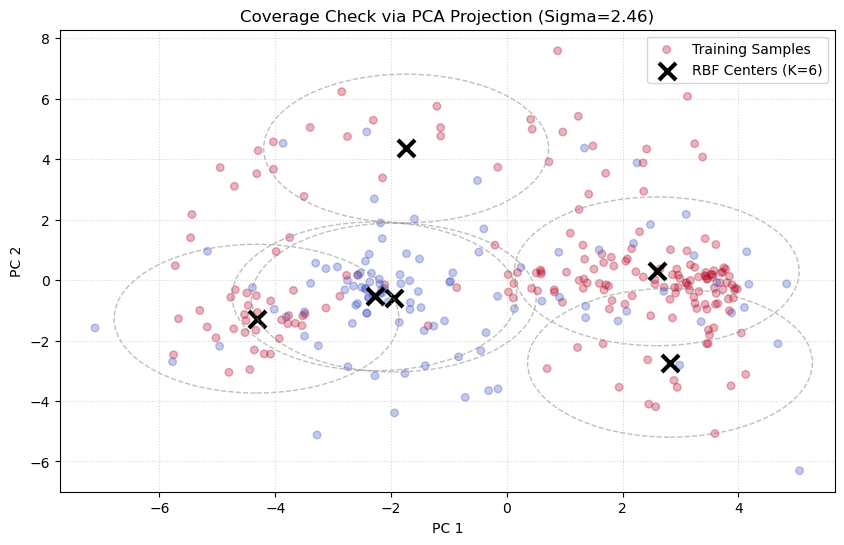

In [48]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)      
C_pca = pca.transform(centres)    

# Draw
plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.flatten(), cmap='coolwarm', 
            alpha=0.3, s=30, label='Training Samples')

plt.scatter(C_pca[:, 0], C_pca[:, 1], c='black', marker='x', 
            s=150, linewidths=3, label=f'RBF Centers (K={rbfnn.n_centres})')

for i in range(C_pca.shape[0]):
    circle = plt.Circle((C_pca[i, 0], C_pca[i, 1]), sigma, color='gray', 
                        fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_artist(circle)
plt.title(f"Coverage Check via PCA Projection (Sigma={sigma:.2f})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('fig/coverage_check_pca.png')
plt.show()

/Users/zimin/opt/miniconda3/envs/Research/lib/python3.11/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


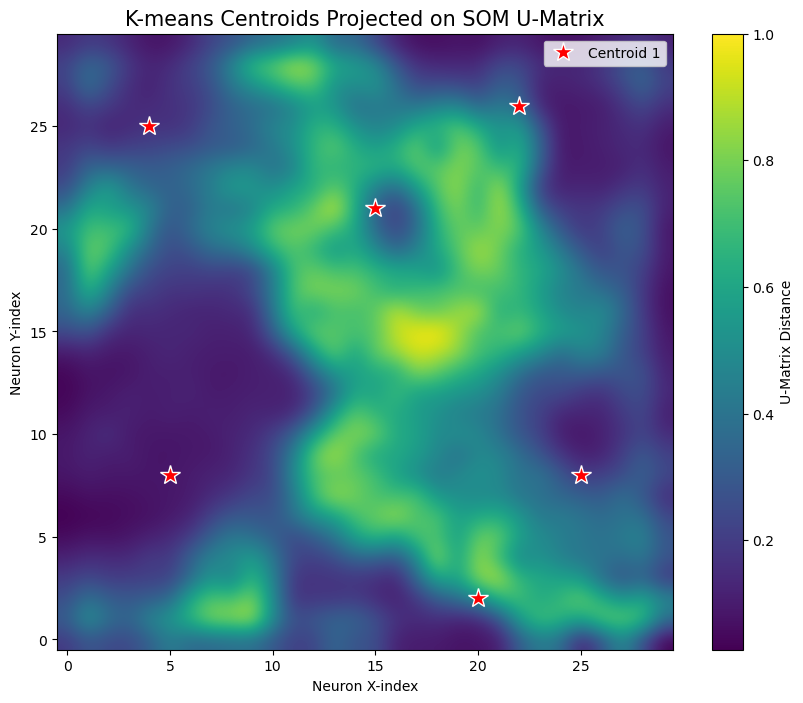

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# 1. 数据准备
scaler = MinMaxScaler()
X_scaled = X

# 2. 获取 K-means 的 8 个中心点
# kmeans = KMeans(n_clusters=6, random_state=42, n_init=10).fit(X_scaled)
# centroids = kmeans.cluster_centers_
kmeans = ncs_Kmeans(X_scaled, n_clusters=6)
centroids, _=kmeans.fit()
# 3. 训练 SOM
som_size = 30 
som = MiniSom(som_size, som_size, X_scaled.shape[1], sigma=2.0, learning_rate=0.5, random_seed=42)
som.pca_weights_init(X_scaled)
som.train_batch(X_scaled, 50000)
u_matrix = som.distance_map().T

# 4. 可视化
plt.figure(figsize=(10, 8))

# 绘制 U-Matrix 背景
img = plt.imshow(u_matrix, cmap='viridis', interpolation='bicubic', origin='lower')
plt.colorbar(label='U-Matrix Distance')

# --- 关键步骤：投影 K-means 中心点 ---
for i, center_vec in enumerate(centroids):
    # 找到该中心点向量在 SOM 网格上的坐标
    w = som.winner(center_vec) 
    # 画出星号，s 代表大小，label 用于图例
    plt.plot(w[0], w[1], 'r*', markersize=15, markeredgecolor='white', label=f'Centroid {i+1}' if i==0 else "")

plt.title('K-means Centroids Projected on SOM U-Matrix', fontsize=15)
plt.xlabel('Neuron X-index')
plt.ylabel('Neuron Y-index')
plt.legend(loc='upper right')
plt.grid(False)
plt.savefig('fig/som_u_matrix_kmeans_centroids.png')
plt.show()

In [36]:
#use backpropogation to adjust sigma and weights
import torch
import torch.nn as nn

class RBFNet(nn.Module):
    def __init__(self, centers, sigma):
        super(RBFNet, self).__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))
        self.weights = nn.Linear(centers.shape[0], 1)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers)
        out = torch.exp(-dists**2 / (2 * self.sigma**2))
        return self.weights(out)
    
model = RBFNet(centres, sigma)
criterion = nn.HuberLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [46]:
import numpy

epochs = 2000
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():

    train_outputs = model(X_tensor)

    train_preds = torch.where(train_outputs >= 0, 1, -1)
    train_acc = (train_preds == y_tensor).float().mean()
    print(f"Training Accuracy: {train_acc.item() * 100:.2f}%")

    test_outputs = model(X_test_tensor)
    y_test_final = np.array(torch.where(test_outputs >= 0, 1, -1).tolist())

    print(f"Prediction: {y_test_final.flatten()}")


Epoch [100/2000], Loss: 0.0634
Epoch [200/2000], Loss: 0.0629
Epoch [300/2000], Loss: 0.0625
Epoch [400/2000], Loss: 0.0621
Epoch [500/2000], Loss: 0.0617
Epoch [600/2000], Loss: 0.0613
Epoch [700/2000], Loss: 0.0609
Epoch [800/2000], Loss: 0.0605
Epoch [900/2000], Loss: 0.0600
Epoch [1000/2000], Loss: 0.0595
Epoch [1100/2000], Loss: 0.0591
Epoch [1200/2000], Loss: 0.0586
Epoch [1300/2000], Loss: 0.0582
Epoch [1400/2000], Loss: 0.0578
Epoch [1500/2000], Loss: 0.0574
Epoch [1600/2000], Loss: 0.0570
Epoch [1700/2000], Loss: 0.0566
Epoch [1800/2000], Loss: 0.0563
Epoch [1900/2000], Loss: 0.0559
Epoch [2000/2000], Loss: 0.0555
Training Accuracy: 98.34%
Prediction: [-1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1
 -1  1 -1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1]


Final Weights: [ 1.72512674  2.53489232  3.36289907  3.22459316 -4.30356646  3.801404  ]
Final Sigma: 3.8807716369628906


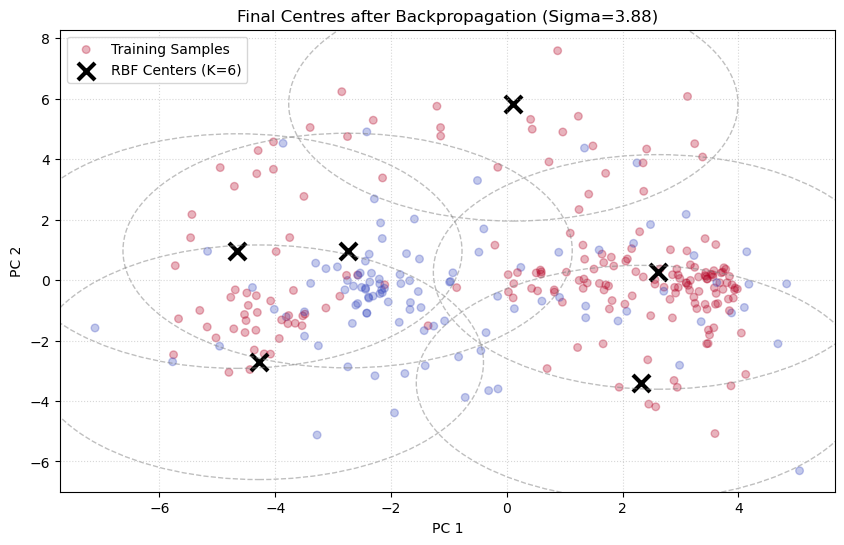

In [47]:
#show weights, sigma and centres position
final_weights=np.array(model.weights.weight.data.tolist()[0])
final_sigma=np.array(model.sigma.data.tolist())
final_centres=np.array(model.centers.data.tolist())
print("Final Weights:", final_weights)
print("Final Sigma:", final_sigma)
##plot centres position
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)     
C_pca = pca.transform(final_centres)   
# Draw
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.flatten(), cmap='coolwarm', 
            alpha=0.3, s=30, label='Training Samples')
plt.scatter(C_pca[:, 0], C_pca[:, 1], c='black', marker='x',
            s=150, linewidths=3, label=f'RBF Centers (K={final_centres.shape[0]})')
for i in range(C_pca.shape[0]):
    circle = plt.Circle((C_pca[i, 0], C_pca[i, 1]), final_sigma.item(), color='gray', 
                        fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_artist(circle)
plt.title(f"Final Centres after Backpropagation (Sigma={final_sigma.item():.2f})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('fig/final_centres_backprop.png')
plt.show()  


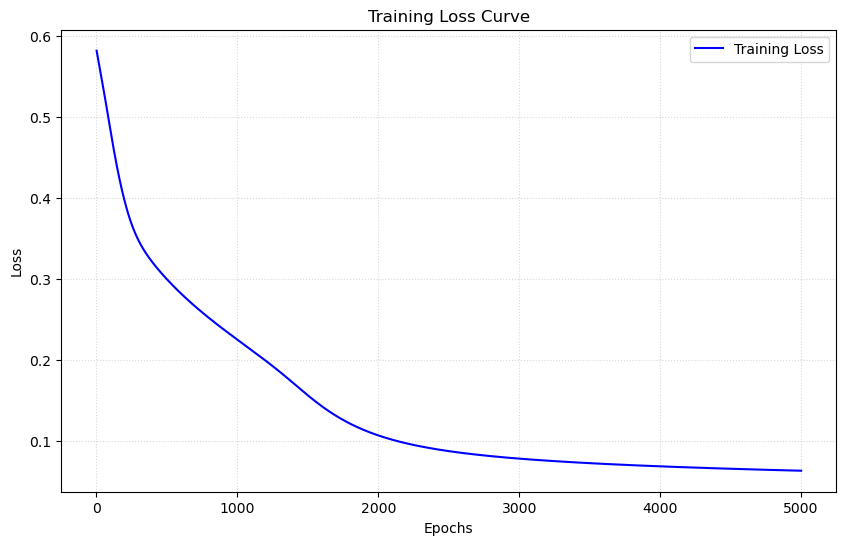

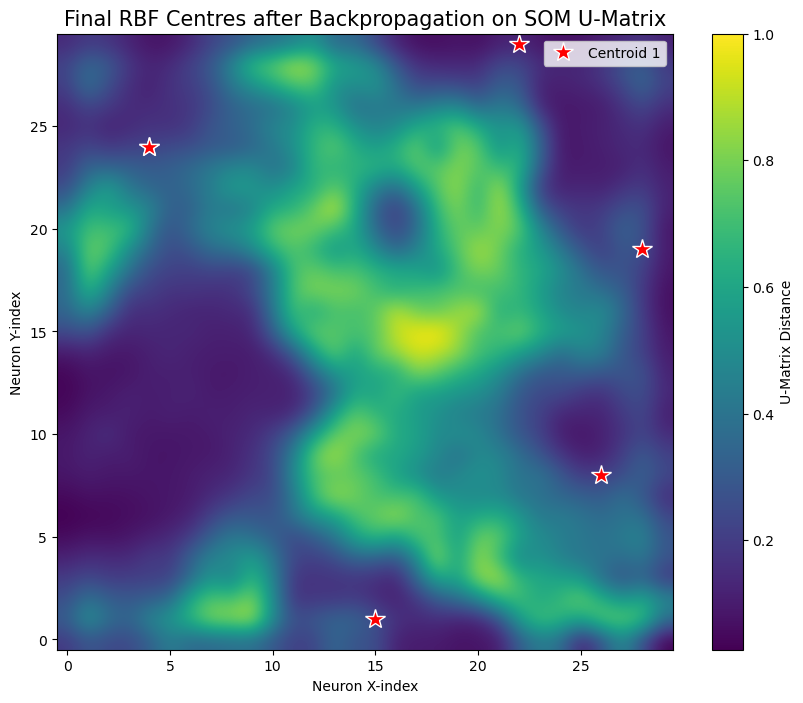

In [39]:
##more figure to evalue the model performance
import matplotlib.pyplot as plt
##plot loss curve
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('fig/training_loss_curve.png')
plt.show()

#project centres on som u-matrix again
plt.figure(figsize=(10, 8))
# 绘制 U-Matrix 背景
img = plt.imshow(u_matrix, cmap='viridis', interpolation='bicubic', origin='lower')
plt.colorbar(label='U-Matrix Distance')     
# --- 关键步骤：投影 K-means 中心点 ---
for i, center_vec in enumerate(final_centres):
    # 找到该中心点向量在 SOM 网格上的坐标
    w = som.winner(center_vec) 
    # 画出星号，s 代表大小，label 用于图例
    plt.plot(w[0], w[1], 'r*', markersize=15, markeredgecolor='white', label=f'Centroid {i+1}' if i==0 else "")
plt.title('Final RBF Centres after Backpropagation on SOM U-Matrix', fontsize=15)
plt.xlabel('Neuron X-index')
plt.ylabel('Neuron Y-index')
plt.legend(loc='upper right')
plt.grid(False)
plt.savefig('fig/som_u_matrix_final_centres.png')
plt.show()